## Single channel superresolution

In [1]:
#imports
import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils

import haiku as hk
import gin
import numpy as np
import xarray
import random

import pickle
from diego_model_utils import SaveObject, forward_pass_module

import matplotlib.pyplot as plt
import seaborn

In [6]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [60]:
#create list of device arrays
def createDataList(data):
    x_shape = len(data.x)
    y_shape = len(data.y)
    high_def = []
    for i in range(int(len(data.time))):
    #     this_time_u = jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape)
    #     this_time_v = jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)
        high_def.append(
                jnp.dstack([
                    jnp.array([data.u.isel(time = i)]).reshape(x_shape, y_shape),
                    jnp.array([data.v.isel(time = i)]).reshape(x_shape, y_shape)]
                )
            )
    return high_def

%time high_def = createDataList(data)

CPU times: user 32.9 s, sys: 1.2 s, total: 34.1 s
Wall time: 45.9 s


(9600, 256, 64, 2)

In [62]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


In [63]:
jnp.shape(high_def)

(8640, 256, 64, 2)

In [64]:
high_def = high_def[0::20]
jnp.shape(high_def)

(432, 256, 64, 2)

In [75]:
print(np.shape(high_def[0][:,:,0]))

(256, 64)


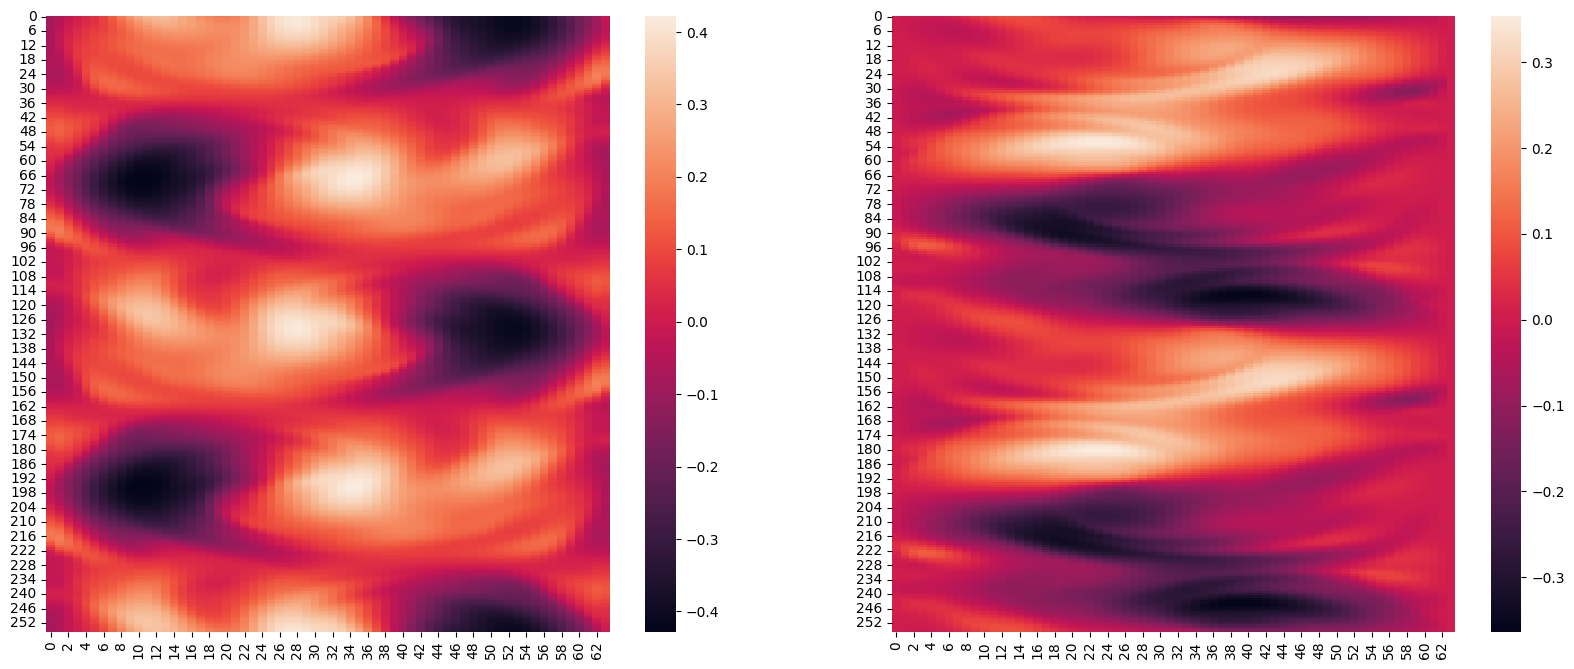

In [77]:
num = 11

fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

im = seaborn.heatmap(high_def[num][:,:,0],ax = axs[0])
# axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(high_def[num][:,:,1],ax = axs[1])

In [81]:
originalMax = np.max(high_def)
originalMin = (np.min(high_def))
print(originalMin,originalMax)

-0.77263814 1.0149648


In [82]:
# scale velocities to beetween zero and one
def scale(input, min=0, max=1):
    
    if min>max:
        raise(ValueError("Min and max may be the wrong way around"))
    
    if min<0:
        og_min = min
        max += -min
        min = 0

    
    input += (min-np.min(input))
    input /= (np.max(input)/max)
    
    try:
        input += og_min
    except:
        pass
    return input

%time scaled_high_def = scale(high_def) #scales all timesteps to same max and min

CPU times: user 36 ms, sys: 1 ms, total: 37 ms
Wall time: 41.1 ms


In [86]:
def increaseSize(input, factor):
    w,h = np.shape(input)
    output = np.zeros((w*factor,h*factor))
    
    for width in range(w*factor):
        for height in range(h*factor):
            output[width][height] = input[width//factor][height//factor]
    return output


def decreaseSize(input,factor):
    w,h = np.shape(input)
    if w%factor != 0 or h%factor != 0:
        raise(AssertionError("Non-compatible input shape and downsample factor"))
    
    output = np.zeros((int(w/factor),int(h/factor)))
    
    for width in range(w):
        for height in range(h):
            output[width//factor][height//factor] += input[width][height]
    output /= factor**len(np.shape(output))
    return output

def downsampleHighDefVels(high_def,factor):
    low_def = []
    for vels in high_def:
        both_vels = []
        for vel in vels:
            vel = decreaseSize(vel,factor)

            vel = increaseSize(vel,factor)
            both_vels.append(vel)
        
        low_def.append(
                jnp.dstack([
                    jnp.array(both_vels[0]),
                    jnp.array(both_vels[1])
                  ]
                )
            )
        low_def.append(both_vels)
    return low_def

CPU times: user 10.5 s, sys: 17.1 ms, total: 10.6 s
Wall time: 10.6 s
CPU times: user 8.27 ms, sys: 981 µs, total: 9.25 ms
Wall time: 9.35 ms


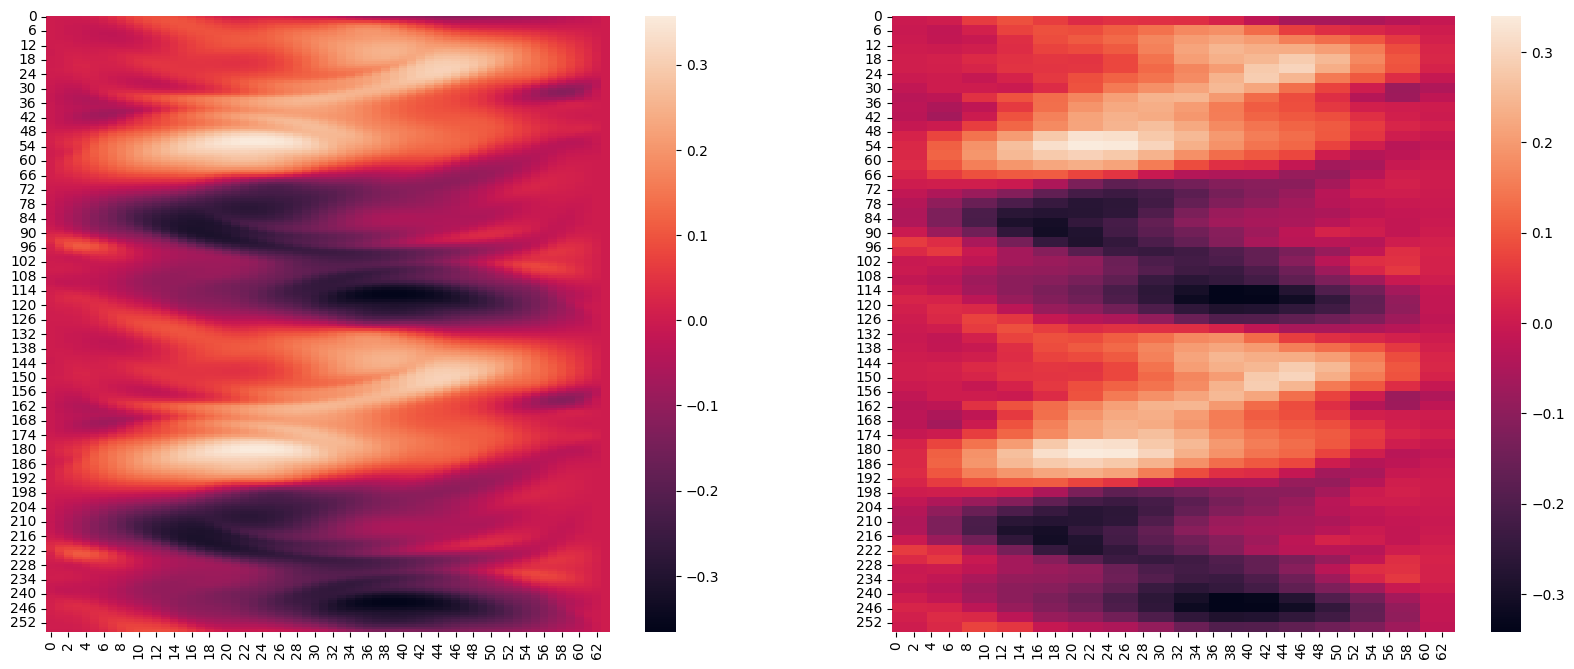

In [95]:
num = 12

fig, axs = plt.subplots(1,2, facecolor='w', edgecolor='k',figsize=(20,8))
# fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

factor = 4
high = high_def[num][:,:,1]
%time low = decreaseSize(high,factor)
%time low = increaseSize(low,factor)

im = seaborn.heatmap(high,ax = axs[0])
# axs[0].title.set_text("Original, high definition")
im = seaborn.heatmap(low,ax = axs[1])

In [96]:
for x in range(10):
    print(x, end='\r')
print()

9
